# Temperature change exposure using ERA weather and climatology, 2000-2015

- Project temperature changes between ERA interim and ERA climatology onto gridded population from NASA for 2000-2015
- Calculate global average as sum of exposure divided by total population

> TODO could be good to also compare to ERA-Land (or select land only cell of ERA) to give indication if changes is mainly due to faster warming over land in general or actually over people specifically. Suspect that since places like canada are warming very fast but have low population, mean warming over land might be even faster than mean warming over people.

## Metric 1.1: Exposure to temperature change

The vulnerability to climate change is a function of the physical hazard (change in temperature, precipitation, humidity etc) and the number of (vulnerable) people exposed. A first order measure of exposure is defined here as:


$$
E(x,t) = \Delta T(x,t)P(x,t)
$$

and the global average is

$$
\bar{E} = \frac{\int \Delta T(x,t)P(x,t) dx}{\int P(x,t) dx}
$$

Where $\Delta T(x,t)$ is the change in the summer mean temperature (Northern Hemisphere JJA, Southern Hemisphere DJF) at location x at time t from the recent historical summer mean (1986-2005). $P(x,t)$ is the population at location x at time t in millions.

**NOTE: The aim of this final indicator is to have an axis in Kelvin, and this is probably the most important one. The reason for this is that it makes it easy to have plots of the raw temperature change and the exposure change side by side and demonstrate with comparable axes that there is an important difference between the change in temperature and the change in temperature experienced by people**


### Updates/Clarifications to Method

Aim is to measure 'temperature change experienced by people'. End goal is a value in Kelvin which is the equivalent of the global mean temperature change but weighted by population

We operate on gridded data.

First, just multiply the temperature change by the number of people at each point (x) for a given time (t):

$$
E(x,t) = \Delta T(x,t)P(x)
$$


We want to limit to the temperature change in the summer months for a given year, so first define all operations for a chosen year Y. The flobal $\Delta T(x,t)$ array is calculated by taking the mean temperature change for June, July, August for the northern hemisphere (latitude >= 0) and joining it with the array ofthe mean temperature change for December, January, February for the southern hemisphere (latitude < 0).

This gives a value in Kelvin x Npeople, which isn't hugely intuitive. When we take the global average with therefore divide by the total population for that year, $\sum P(x)$:

$$
\bar{E} = \frac{\sum \Delta T(x,t)P(x,t)}{\sum P(x)}
$$

This can be repeated for each year to get a time series. However, we'd also like to map the value for each year in a similarly intuitive way. We can do this using the mean population per grid point:

$$
\bar{P} = \sum P(x) / N
$$

And calculating the exposure at each point as the population divided by the mean population:

$$
E(x,t) = \Delta T(x,t)P(x) / \bar{P}
$$

The average of this value over the grid (with number of points N) is equal to the $\bar{E}$:


$$
Mean = \frac{\sum \Delta T(x,t)P(x,t) / \bar{P} }{N} \\
= \frac{\sum \Delta T(x,t)P(x,t) / (\sum P(x) / N) }{N} \\
= \frac{ \tfrac{N}{\sum P(x)} \sum \Delta T(x,t)P(x,t) }{N} \\
= \frac{ N   \sum \Delta T(x,t)P(x,t) }{N \sum P(x)} \\
= \frac{\sum \Delta T(x,t)P(x,t)}{\sum P(x)} = \bar{E} 
$$


### Notes

Summer:

Northern Hemisphere JJA: June, July, August

Southern Hemisphere DJF: December, January, February



In [1]:
from datetime import date
from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from scipy import stats

from config import (DATA_SRC, WEATHER_SRC, POP_DATA_SRC)

In [2]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['figure.figsize'] = (5, 2.7)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['legend.fontsize'] = 'small'

In [3]:
MAX_YEAR = 2021

In [5]:
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

ERA_MONTHLY_FOLDER = WEATHER_SRC / 'era5_0.25deg' / 'monthly_means'
CLIMATOLOGY_FILE_MONTHLY = WEATHER_SRC / 'era5_0.25deg' / 'era_climatology_monthly.nc'

POPULATION_FILE = DATA_SRC/ 'lancet/population/UN WPP-Adjusted Population Count v4.11 2000-2020 15min era compat.nc'
POPULATION_VAR = 'UN WPP-Adjusted Population Count, v4.11 (2000-2020)'

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'summer_temperature'/ 'results_2022'
INTERMEDIATE_RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

DEMOGRAPHICS_TOTALS_FILE = POP_DATA_SRC / 'demographics_hybrid_1950_2020_15_min_era_compat.nc'

In [6]:
RESULTS_FOLDER = Path('../results/summer temperature change')
RESULTS_FOLDER.mkdir(exist_ok=True, parents=True)
assert RESULTS_FOLDER.is_dir()

In [7]:
MAP_PROJECTION = ccrs.EckertIII()

# Load weather

In [8]:
temperature_monthly = xr.open_mfdataset(sorted(ERA_MONTHLY_FOLDER.glob('*.grib')), engine='cfgrib', combine='nested', concat_dim='time').t2m

In [9]:
climatology = xr.open_dataset(CLIMATOLOGY_FILE_MONTHLY).t2m

## Get ∆T for each month of each year relative to the ERA climatology monthly means file


In [9]:
def sub_months(era_t_yr):
    #Swap in the time axis so the datasets auto-align
    tmp = climatology.copy().rename({'month':'time'})
    tmp['time'] = era_t_yr.time
    return era_t_yr - tmp
    
delta_t = temperature_monthly.groupby('time.year').apply(sub_months)

In [10]:
# import ipywidgets

# def _plt_month(month=1, year=2000):
#     (delta_t.sel(time=date(year, month, 1))).plot.imshow(vmin=-5, vmax=5, cmap='RdBu_r')

# ipywidgets.interact(_plt_month, 
#          month=ipywidgets.IntSlider(min=1,max=12,step=1,value=1),
#          year=ipywidgets.IntSlider(min=1980,max=MAX_YEAR,step=1,value=2000)
#         );


/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_m

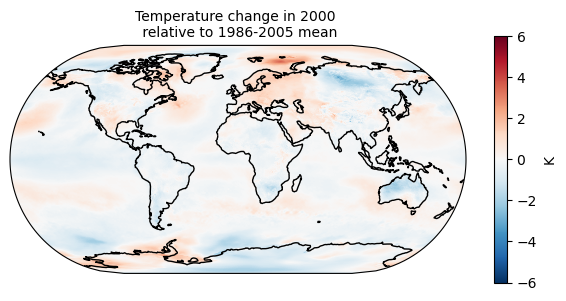

In [47]:
# Climate change in 2000
f, ax = plt.subplots(figsize=(6,3), subplot_kw=dict(projection=MAP_PROJECTION))

delta_t.sel(time='2000').mean(dim='time').plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label='K'),
    cmap='RdBu_r',
    vmin=-6, vmax=6
)
ax.coastlines()
ax.set_title('Temperature change in 2000 \n relative to 1986-2005 mean')
plt.tight_layout()

f.show()

f, ax = plt.subplots(figsize=(6,3), subplot_kw=dict(projection=MAP_PROJECTION))

delta_t.sel(time=f'{MAX_YEAR}').mean(dim='time').plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label='K'),
    cmap='RdBu_r',
    vmin=-6, vmax=6
)
ax.coastlines()
ax.set_title(f'Temperature change in {MAX_YEAR} \n relative to 1986-2005 mean')
# plt.tight_layout()

f.show()

## Get the mean delta for each summer

In [10]:
def collect_summer_delta(delta_t):
    """Split the word data into north and south, 
    keep only the summer months for each, then re-join them
    """
    # Wrap in a function to clear temporary vars from memory
    
    lat_north = delta_t.latitude[delta_t.latitude >= 0]    
    lat_south = delta_t.latitude[delta_t.latitude < 0]

    # Summer North
    summer_jja = delta_t['time.season'] == 'JJA'

    # Summer South
    summer_djf = delta_t['time.season'] == 'DJF'

    nh = delta_t.sel(time=summer_jja, latitude=lat_north).groupby('time.year').mean(dim='time')
    sh = delta_t.sel(time=summer_djf,latitude=lat_south).groupby('time.year').mean(dim='time')
    
    return xr.concat([nh, sh], dim='latitude')

summer_anom = collect_summer_delta(delta_t)

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.9/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.9/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': Tr

In [11]:
# Clean up the data a bit
summer_anom = summer_anom.drop(['surface','step', 'number'])

In [14]:
# def _plt_delta(year=2000):
#     summer_anom.sel(year=year).plot(vmin=-5, vmax=5, cmap='RdBu_r')

# ipywidgets.interact(_plt_delta, 
#          month=ipywidgets.IntSlider(min=1,max=12,step=1,value=1),
#          year=ipywidgets.IntSlider(min=1980,max=MAX_YEAR,step=1,value=2000)
#         );


In [12]:
f, ax = plt.subplots(figsize=(6,3), subplot_kw=dict(projection=MAP_PROJECTION))


summer_anom.sel(year=MAX_YEAR).plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label='[˚C]'),
    cmap='RdBu_r',
    vmin=-6, vmax=6
)
ax.coastlines(linewidth=0.5)
ax.set_title(f'Summer temperature anomaly in {MAX_YEAR} \n relative to 1986-2005 baseline')
# plt.tight_layout()
f.savefig(RESULTS_FOLDER / f'summer_temperature_map_{MAX_YEAR}.png', dpi=300)
f.savefig(RESULTS_FOLDER / f'summer_temperature_map_{MAX_YEAR}.pdf', dpi=300)

f.show()

### Save the summer anomaly for use in the country calculation

In [16]:
# summer_anom.name = 'summer_global'
summer_anom.to_netcdf(INTERMEDIATE_RESULTS_FOLDER /'summer_temperature_anomaly.nc')

In [10]:
summer_anom = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER /'summer_temperature_anomaly.nc')

### Weight the gridded mean anomaly by the latitude and calculate the global mean

- It's important to weight the grid before calculating the mean to account for the change in area of grid units from the equator to the poles

In [11]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(summer_anom.latitude))
summer_anom_ts = (summer_anom * cos_lat).mean(dim=['latitude', 'longitude']).compute()

/tmp/ipykernel_644129/3566324841.py:1: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(summer_anom.latitude))
/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.9/site-packages/xarray/core/dataarray.py:3061: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))
/tmp/ipykernel_644129/3566324841.py:1: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(summer_anom.latitude))
/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.9/site-packages/xarray/core/dataarray.py:3061: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))


# Project summer anomaly to total population

In [18]:
population = xr.open_dataset(DEMOGRAPHICS_TOTALS_FILE).sum(dim='age_band_lower_bound').demographic_totals

In [17]:
# population = xr.open_dataset(POPULATION_FILE)[POPULATION_VAR]

In [21]:
population = (
    xr.concat([population, 
               population.interp(year=2021, kwargs=dict(fill_value="extrapolate")).compute()
              ], 'year').load())

In [22]:
# POPULATION_FILE_EXTENDED = POP_DATA_SRC / 'population_ismip_and_gpw4_era_compat.nc'
# population_extended =  xr.open_dataarray(POPULATION_FILE_EXTENDED)

## Calculate the exposure

In [23]:
summer_exposures_ts = (summer_anom * population / population.sum(dim=['latitude', 'longitude'], skipna=True)).sum(dim=['latitude', 'longitude'], skipna=True)

In [24]:
summer_exposures_ts = summer_exposures_ts.compute()

## Save/load the exposure time series

In [16]:
summer_exposures_ts.name = 'summer_exposure'
summer_exposures_ts.to_dataframe().to_excel(RESULTS_FOLDER / 'summer_exposure_ts.xlsx')


NameError: name 'summer_exposures_ts' is not defined

In [17]:
summer_exposures_ts = pd.read_excel(RESULTS_FOLDER / 'summer_exposure_ts.xlsx', index_col='year')
summer_exposures_ts = summer_exposures_ts.to_xarray().summer_exposure


In [19]:
# Save to excel
summer_anomalies_summary = summer_anom_ts.to_dataframe(name='Global mean change K').join(summer_exposures_ts.to_dataframe(name='Exposure weighted change K'))

summer_anomalies_summary.to_excel(RESULTS_FOLDER / 'summer_temperature_anomaly.xlsx', sheet_name='temperature_change')
summer_anomalies_summary.to_csv(RESULTS_FOLDER / 'summer_temperature_anomaly.csv')

In [29]:
summer_anomalies_summary =pd.read_excel(RESULTS_FOLDER / 'summer_temperature_anomaly.xlsx', sheet_name='temperature_change').set_index('year')


## Plot the time series

In [31]:
summer_anom_ts.sel(year=2020).item()

0.3352816134623665

In [32]:
summer_exposures_ts.sel(year=2020).item()

0.598522039974367

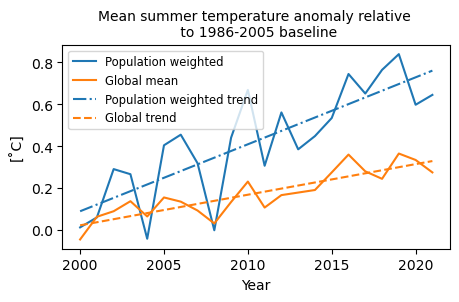

In [22]:
summer_exposures_ts.plot(color='C0',label='Population weighted')

# Don't have population data before 2000 in this analysis (could use the merged one)
summer_anom_ts.sel(year=slice(2000,None)).plot(color='C1',label='Global mean')
# mean_exposures_ts.plot(color='C9', label='Experienced, Year 2000 baseline')

summer_anom_params = stats.linregress(summer_anom_ts.sel(year=slice(2000,None)).year.values, summer_anom_ts.sel(year=slice(2000,None)).values)
summer_anom_reg = (summer_anom_params.slope * summer_anom_ts.sel(year=slice(2000,None)).year) + summer_anom_params.intercept

summer_exposures_params = stats.linregress(summer_exposures_ts.year.values, summer_exposures_ts.values)
summer_exposures_reg = (summer_exposures_params.slope * summer_exposures_ts.year) + summer_exposures_params.intercept

summer_exposures_reg.plot.line('-.', color='C0', label='Population weighted trend')
summer_anom_reg.plot.line('--', color='C1', label='Global trend')

plt.xticks(list(range(2000, MAX_YEAR + 1, 5)))
plt.xlabel('Year')
plt.ylabel('[˚C]')
plt.title('Mean summer temperature anomaly relative \n to 1986-2005 baseline')
plt.legend();
plt.savefig(RESULTS_FOLDER / f'summer_warming_2000-{MAX_YEAR}.png')
plt.savefig(RESULTS_FOLDER / f'summer_warming_2000-{MAX_YEAR}.pdf')


In [34]:
summer_anom_params

LinregressResult(slope=0.014587175196396174, intercept=-29.150680641345033, rvalue=0.8647814136074078, pvalue=2.0859108664834944e-07, stderr=0.001894008901946574, intercept_stderr=3.8079238562465827)

In [35]:
summer_exposures_params

LinregressResult(slope=0.031928612796272765, intercept=-63.76653178555775, rvalue=0.8086085160491048, pvalue=5.260145560474907e-06, stderr=0.005194698330212342, intercept_stderr=10.443992991421455)

In [31]:
summer_exposures_params.slope / summer_anom_params.slope

2.54220029806197

# Plot the summer trends using the extended population file

Gives a longer time series to better understand the trends

In [23]:
# Load the 2020 results to get the pre-2000 extended values calculated on the 0.5 degree grid
summer_anom_extended_ts = pd.read_excel('../../2020 material/results/summer temperature change/summer_temperature_anomaly.xlsx').set_index('year')

In [24]:
summer_anom_params = stats.linregress(summer_anom_extended_ts.index.values, summer_anom_extended_ts['Global mean change K'].values)
summer_anom_reg = (summer_anom_params.slope * summer_anomalies_summary.index.values) + summer_anom_params.intercept

summer_exposures_params = stats.linregress(summer_anom_extended_ts.index.values, summer_anom_extended_ts['Exposure weighted change K'].values)
summer_exposures_reg = (summer_exposures_params.slope * summer_anom_extended_ts.index.values) + summer_exposures_params.intercept


In [25]:
summer_anom_params

LinregressResult(slope=0.010759525762908256, intercept=-21.457902839405026, rvalue=0.8803868539016598, pvalue=3.314636333286632e-14, stderr=0.0009281118916043858, intercept_stderr=1.8553281711988006)

In [26]:
summer_exposures_params

LinregressResult(slope=0.027352869601470813, intercept=-54.558264504543, rvalue=0.8857333495777878, pvalue=1.4280787498927042e-14, stderr=0.0022954481316171476, intercept_stderr=4.588681195273698)

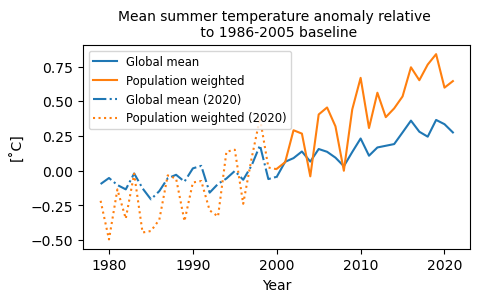

In [28]:
summer_anomalies_summary.loc[2000:]['Global mean change K'].plot(color='C0',label='Global mean')
summer_anomalies_summary.loc[2000:]['Exposure weighted change K'].plot(color='C1',label='Population weighted')


summer_anom_extended_ts['Global mean change K'].loc[:2000].plot.line(linestyle='dashdot', color='C0',label='Global mean (2020)')
summer_anom_extended_ts['Exposure weighted change K'].loc[:2000].plot.line(linestyle='dotted', color='C1',label='Population weighted (2020)')


# summer_exposures_reg.plot.line('-.', color='C0', label='Population weighted trend')
# summer_anom_reg.plot.line('--', color='C1', label='Global trend')

plt.xlabel('Year')
plt.ylabel('[˚C]')
plt.title('Mean summer temperature anomaly relative \n to 1986-2005 baseline')
plt.legend();
plt.savefig(RESULTS_FOLDER / f'summer_warming_1980-{MAX_YEAR}.png')
plt.savefig(RESULTS_FOLDER / f'summer_warming_1980-{MAX_YEAR}.pdf')

In [44]:
summer_exposures_params

LinregressResult(slope=0.027352869601470813, intercept=-54.558264504543, rvalue=0.8857333495777878, pvalue=1.4280787498927042e-14, stderr=0.0022954481316171476, intercept_stderr=4.588681195273698)